# <center>Тема 4
## <center>Нейронні мережі в задачах прогнозування (регресії)

### <center>Загальні відомості

Задачі прогнозування відрізняються від задач класифікації тим, що цілі Y є не номерами класів, а мають кількісну шкалу (грн, $, кг, В тощо). Відповідно, у вихідному прошарку мережі завжди буде лише один нейрон. Окрім того, до вихідного прошарку не застосовується жодна активаційна функція (або використовується лінійна). Прикладами регресії є прогнозування прибутку, прогноз погоди, прогнозування обсягів продажів або цін на товари. З технічної точки зору, нейронні мережі прямого розповсюдження для прогнозування нічим не відрізняються від аналогічних мереж для класифікації. Важливо лише правильно подібрати метрики та критерії якості і підготувати дані для аналізу.

- Критерії якості для задач регресії в Keras: https://keras.io/api/losses/regression_losses/
- Метрики для задач регресії в Keras: https://keras.io/api/metrics/regression_metrics/

Одним із прикладів задач регресії є прогнозування часових послідовностей (часових рядів). 

Часовий ряд (англ. time series) — це ряд точок даних, проіндексованих (або перелічених, або відкладених на графіку) в хронологічному порядку. Найчастіше часовий ряд є послідовністю, взятою на рівновіддалених точках в часі, які йдуть одна за одною. Таким чином, він є послідовністю даних дискретного часу. Прикладами часових рядів є висоти океанських припливів, кількості сонячних плям, та щоденне значення вартості акцій на момент закриття торгів. (<a href = 'https://uk.wikipedia.org/wiki/%D0%A7%D0%B0%D1%81%D0%BE%D0%B2%D0%B8%D0%B9_%D1%80%D1%8F%D0%B4'>Wikipedia</a>)

Найраще в цих задачах себе проявляють мережі довгої короткострокової пам'яті (Long Short-Term Memory, LSTM). Але зараз ми навчимось вирішувати цю задачу із використанням вже знайомих нам Feedforward мереж.

### <center>Підготовка даних

Розглянемо набір даних про обсяг пасажирських перевезень у США за 1949 - 1960 роки. Цей приклад є класичним і найбільш демонстративним щоб гарно розібратись з усіма особливостями прогнозування рядів. 

Задача: необхідно зробити прогноз обсягів пасажирських перевезень на 12 місяців вперед.

Для початку імпортуємо необхідні бібліотеки.

In [1]:
import numpy
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
# Розмір графіків
plt.rcParams['figure.figsize'] = (15, 5)

Завантажимо навчальну вибірку - часовий ряд, на основі якого будемо робити прогноз.

In [2]:
ser_g = pd.read_csv('D:/Drive/ІІС/Datasets/Time_series/series_g.csv', sep=';', header=0)

Переглянемо заголовок і кінець таблиці:

In [3]:
ser_g.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [4]:
ser_g.tail()

,date,series_g
139,AUG 1960,606
140,SEP 1960,508
141,OCT 1960,461
142,NOV 1960,390
143,DEC 1960,432


Як бачимо, дані організовані по місяцям. В стовпці *date* - місяць і рік, в стовпці *sreies_g* - обсяг пасажирських перевезень за відповідний час.

Переглянемо, скільки всього записів є в наборі даних.

In [5]:
ser_g.shape

(144, 2)

Отже, маємо дані за 144 місяці.

Тепер побудуємо графік, щоб відповісти на 4 питання:
- Чи є тренд? Тренд - це загальна тенденція в поведінці ряду. Тренд описує, як змінюються середні значення ряду із часом. Якщо тренд є, потрібно оцінити його характер: зростаючий/спадаючий, лінійний/експоненціальний/затухаючий тощо.
- Чи є сезонність? Сезонність - періодичні зміни значень ряду з часом. Якщо є сезонність, то яка вона? Який період сезону? Сезонність адитивна (значення сезонних поправок мають постійну амплітуду відносно лінії тренду) чи мультиплікативна (значення сезонних поправок збільшуються/зменшуються пропорційно зростанню/спаданню тренду)? Якщо сезонність мультиплікативна, її потрібно привести до адитивної (наприклад, прологарифмувавши значення ряду).
- Чи змінює ряд свій характер? Зміну характеру можна виявити за різкою зміною тренду. Якщо ряд змінює свій характер, для прогнозування необхідно використовувати лише останню його ділянку, на якій характер ряду незмінний.
- Чи є викиди або пропущені значення? Викиди - аномально великі або маленькі значення в ряді. Якщо вони є, їх потрібно замінити більш "розумними" значеннями (найчастіше - середнім або медіаною між сусідніми відносно викиду спостереженнями).

<AxesSubplot:>

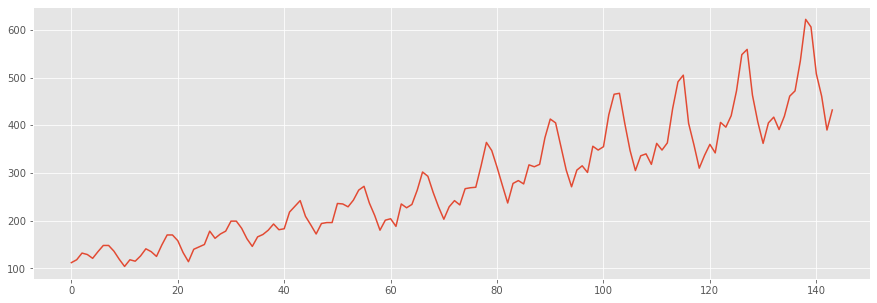

In [6]:
#  Графік щоб відповісти на 4 питання
ser_g.iloc[:,1].plot()

Аналізуємо графік:
- Ряд має зростаючий лінійний тренд
- Ряд має мультиплікативну сезонність
- Ряд не змінює свій характер
- Викидів або пропущених значень немає

Оскільки сезонність мультиплікативна, її потрібно привести до адитивної, використавши логарифмування. Таким чином, модель буде вчитись робити прогноз для логарифму ряду, а не самого ряду.

In [5]:
#  Потрібно прогнозувати логарифм
ser_g['log_y'] = numpy.log10(ser_g['series_g'])

Text(0, 0.5, 'log10 від тисяч осіб')

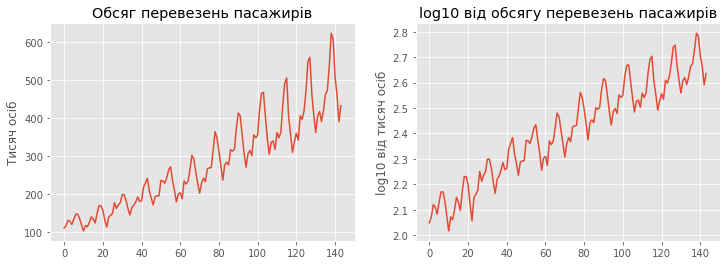

In [8]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ser_g['series_g'].plot(ax=ax1)
ax1.set_title(u'Обсяг перевезень пасажирів')
ax1.set_ylabel(u'Тисяч осіб')

ax2 = fig.add_subplot(122)
pd.Series(ser_g['log_y']).plot(ax=ax2)
ax2.set_title(u'log10 від обсягу перевезень пасажирів')
ax2.set_ylabel(u'log10 від тисяч осіб')


Тепер необхідно перетворити дані так, щоб отримати таблицю предикторів Х та цілей Y. Оскільки тривалість сезону в нашому випадку складає 12 місяців (1 рік), то логічно буде за дванадцятьма попередніми місяцями робити прогноз на один наступний місяць. Тобто для одного рядка навчальних даних буде 12 стовпців X та один стовпець Y. 

Під час навчання:
- За значеннями спостережень №1-№12 прогнозуємо спостереження №13 - це буде перша ітерація навчання (перший рядок навчальних даних). Предиктори Х - спостереження №1-№12, ціль Y - спостереження №13.
- Зсуваємось на 1 місяць вперед. За значеннями спостережень №2-№13 прогнозуємо спостереження №14 (це буде другий рядок навчальних даних).
- Зсуваємось на 1 місяць вперед. За значеннями спостережень №3-№14 прогнозуємо спостереження № 15.
- Крок за кроком проходимо по всіх навчальних даних.

Виконаємо необхідні перетворення даних.

In [9]:
ser_g_2 = pd.DataFrame()

for i in range(12,0,-1):
    ser_g_2['t-'+str(i)] = ser_g.iloc[:,2].shift(i)

ser_g_2['t'] = ser_g.iloc[:,2].values

print(ser_g_2.head(13))

        t-12      t-11      t-10       t-9       t-8       t-7       t-6  \
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6        NaN       NaN       NaN       NaN       NaN       NaN  2.049218   
7        NaN       NaN       NaN       NaN       NaN  2.049218  2.071882   
8        NaN       NaN       NaN       NaN  2.049218  2.071882  2.120574   
9        NaN       NaN       NaN  2.049218  2.071882  2.120574  2.110590   
10       NaN       NaN  2.049218  2.071882  2.120574  2.110590  2.082785   
11       NaN  2.049218  2.071882  2.120574  2.110590  2.082785  2.130334   
12  2.049218

Відрізаємо перші 12 рядків.

In [10]:
ser_g_4 = ser_g_2[12:]

ser_g_4.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
12,2.049218,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698
13,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371
14,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219
15,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334
16,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334,2.096910


Навчальна таблиця даних готова. Тепер розділяємо предиктори та цілі

In [11]:
# Цілі -  вектор y
y = ser_g_4['t']
# Предиктори - таблиця X
X = ser_g_4.drop('t', axis=1)

Розділяємо дані на навчальну і тестову множини. Тестова множина у випадку прогнозування часових рядів - останні спостереження. Оскільки нам важливо отримати точний прогноз саме для останнього періоду часу.

In [12]:
# Знадаємо, скільки рядків в навчальній таблиці
ser_g_4.shape

(132, 13)

In [13]:
#  Візьмемо останні 12 спостережень в якості тестової вибірки
X_train = X[:120]
y_train = y[:120]
X_test  = X[120:]
y_test  = y[120:]

In [14]:
#  Все добре?
print(ser_g_4.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(132, 13)
(120, 12)
(120,)
(12, 12)
(12,)


In [15]:
#  Все добре?
X_train.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
12,2.049218,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882
13,2.071882,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698
14,2.120574,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371
15,2.110590,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219
16,2.082785,2.130334,2.170262,2.170262,2.133539,2.075547,2.017033,2.071882,2.060698,2.100371,2.149219,2.130334


Навчальні дані готові. Можемо створити і навчити нейронну мережу. В якості критерію якості використаємо *mean_squared_error*, метрика - *mean_absolute_percentage_error*. Активаційна функція вихідного нейрону - лінійна `activation='linear'`. Розділяти вибірку на батчі не будемо (даних і так мало) - `batch_size=None`

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [68]:
# Створюємо модель
model = Sequential()
model.add(Dense(8, input_dim=12, activation='relu'))
model.add(Dense(1, activation='linear'))

# Компілюємо модель
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

# Навчаємо модель
model.fit(X_train, y_train, epochs=300, batch_size=None)

Epoch 1/300
4/4 [==============================] - 0s 3ms/step - loss: 15.8941 - mean_absolute_percentage_error: 165.0730
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 14.2706 - mean_absolute_percentage_error: 156.3631
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 12.4993 - mean_absolute_percentage_error: 146.3124
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 10.7878 - mean_absolute_percentage_error: 135.9245
Epoch 5/300
4/4 [==============================] - 0s 2ms/step - loss: 9.2152 - mean_absolute_percentage_error: 125.5731
Epoch 6/300
4/4 [==============================] - 0s 3ms/step - loss: 7.7806 - mean_absolute_percentage_error: 115.3880
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 6.4992 - mean_absolute_percentage_error: 105.4709
Epoch 8/300
4/4 [==============================] - 0s 0s/step - loss: 5.3749 - mean_absolute_percentage_error: 95.8276
Epoch 9/300
4/4 [=============

Виконаємо грубу оцінку якості моделі на тестових даних. Грубу - тому що таким способом ми уникаємо "накопичення помилки", оскільки використовуємо заздалегідь відомі значення всіх предикторів.

In [65]:
scores = model.evaluate(X_test, y_test)
print("\n rude MAPE: %.2f%%" % (scores[1]))

1/1 [==============================] - 0s 0s/step - loss: 0.0041 - mean_absolute_percentage_error: 1.9710

 rude MAPE: 1.97%


Обчислюємо грубий прогноз на тестових даних.

In [48]:
false_predictions = model.predict(X_test)

Для правильної оцінки якості роботи мережі на тесових даних необхідно реалізувати наступний алгоритм:
- Взяти перший набір предикторів із тестових даних. В нашому випадку, це спостереження №109-№120. За їх значеннями спрогнозувати спостереження №121.
- Взяти спостереження №110-№121 (спрогнозоване на попередньому кроці). За ними спрогнозувати спостереження №122.
- Взяти спостереження №110-№122 (два останні - спрогнозовані на попередніх кроках). За ними спрогнозувати спостереження №123.
- Повторювати ці дії стільки разів, скільки значень потрібно спрогнозувати. В нашому випадку - 12.
- Лише після цього оцінити значення метрики, порахувавши помилки як різницю між реальними цілями *у* та спрогнозованими значеннями. Це треба зробити за власною формулою, а не стандартним методом `evaluate()`!

Напишемо власну функцію для прогнозування за описаним алгоритмом.

In [49]:
def make_prediction(X_predict, nb_of_predictions):

    predictions = numpy.array([])

    for i in range (nb_of_predictions):

        y_predicted = model.predict(X_predict)
        predictions = numpy.append(predictions, y_predicted)
    
        X_predict = numpy.roll(X_predict, -1)
        X_predict[0][-1] = y_predicted
    
    return predictions

Проведемо оцінку якості моделі за метрикою MAPE.

In [50]:
# Перетворимо перший зразок із тестової вибірки на масив Numpy
X_predict = numpy.array(X_test[:1])

# Використаємо написану функцію для отримання правильного прогнозу
predictions = make_prediction(X_predict, len(X_test))

Отримаємо значення MAPE на тестових даних.

In [51]:
y_test = numpy.array(y_test)

MAPE = 100*sum(numpy.abs(y_test - predictions) / numpy.maximum(y_test, 1e-20))/len(y_test)
print(f"\n MAPE: {MAPE:.2f} %")


 MAPE: 1.12 %


Обчислюємо допасування ("підгонку") моделі. Підгонка показує, наскільки якісно модель робить прогнози на навчальній множині. Порівнявши результати роботи мережі з правильними значеннями Y, можна візуально (на графіку) оцінити, наскільки близькими є прогнози моделі до реальних даних, на яких вона навчалась.

In [52]:
predictions_train = model.predict(X_train)

Згадуємо розміри таблиць і будуємо графіки.

In [53]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(120, 12)
(120,)
(12, 12)
(12,)


- Було 144 спостереження
- Відкинули 12, стало 132
- train 120
- test 12

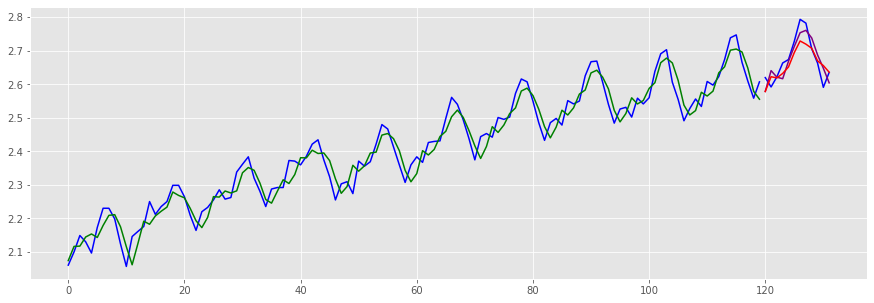

In [54]:
# Графік з результатами

plt.rcParams['figure.figsize'] = (15, 5)

#   numpy.arange([start, ]stop, [step, ]dtype=None)

x2 = numpy.arange(0, 120, 1)

x3 = numpy.arange(120, 132, 1)

# реальні дані (початковий ряд без відкинутих і тестових значень)
plt.plot(x2, y_train, color='blue')

# підгонка
plt.plot(x2, predictions_train, color='green')

# реальні дані на тестовій множині
plt.plot(x3, y_test, color='blue')

# грубий прогноз на тестовій множині
plt.plot(x3, false_predictions, color='purple')

# правильний прогноз на тестовій множині
plt.plot(x3, predictions, color='red')

Якщо результати роботи мережі нас задовольняють, можна використати навчену модель для створення реального прогнозу. Якщо ні - перенавчаємо. Реальний прогноз є продовженням початкового ряду на певну кількість спостережень. В нашому випадку - на 12 місяців вперед. Для створення прогнозу використаємо раніше написану нами функцію `make_prediction()`. Кількість предикторів X має відповідати кількості стовпців Х в таблиці даних, на якій навчалась мережа. В нашому випадку, в якості першого набору предикторів Х необхідно подати дані за останні 12 місяців з початкового ряду.

In [55]:
# Прогнозуємо на 12 місяців вперед
nb_of_predictions = 12

# Перетворюємо дані за останні 12 місяців в масиви Numpy
X_real_prediction = numpy.array(ser_g_4.iloc[-X.shape[1]:,1])
X_real_prediction = numpy.expand_dims(X_real_prediction, axis = 1)
X_real_prediction = numpy.transpose(X_real_prediction)

# Робимо прогноз
real_predictions = make_prediction(X_real_prediction, nb_of_predictions)

Побудуємо суміщений графік, на якому покажемо початковий ряд та прогноз на наступні 12 місяців.

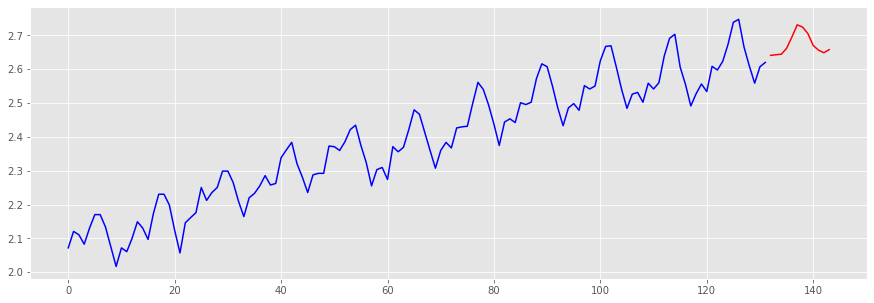

In [56]:
# Даня з початкового ряду
x_past = numpy.arange(0, len(ser_g_4))
y_past = ser_g_4.iloc[:,1]

# Додаємо координати Х для прогнозу
x_pred = numpy.arange(len(ser_g_4), len(ser_g_4) + nb_of_predictions)

# Початковий ряд
plt.plot(x_past, y_past, color='blue')

# Прогноз
plt.plot(x_pred, real_predictions, color='red')

Оскільки ми навчили мережу прогнозувати логарифми даних, а не самі дані, необхідно виконати зворотне перетворення - піднесення до степеню. Логарифм був десятковим, тому для отримання реальних результатів (кількості осіб, а не її логарифмів) необхідно піднести 10 до відповідного ступеню.

In [57]:
# Перетворюємо з логарифмів до реальної величини
non_log_predictions = 10**real_predictions

Тепер побудуємо фінальний графік.

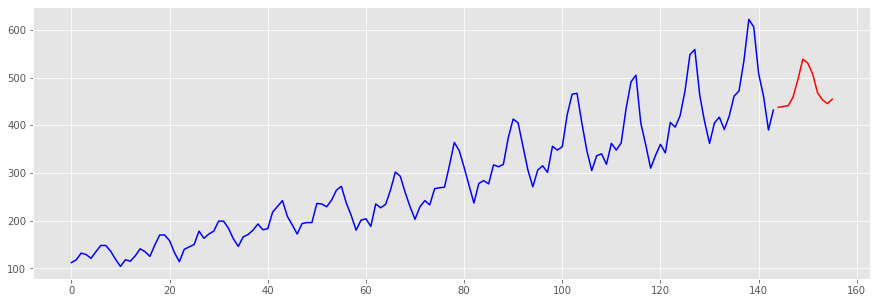

In [58]:
x_past = numpy.arange(0, len(ser_g))
y_past = ser_g.iloc[:,1]

x_pred = numpy.arange(len(ser_g), len(ser_g) + nb_of_predictions)

plt.plot(x_past, y_past, color='blue')
plt.plot(x_pred, non_log_predictions, color='red')